In [3]:
from pyspark.sql.functions import mean, udf, col, round
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

sc = SparkContext('local')
spark = SparkSession(sc)

%matplotlib inline
now = datetime.datetime.now()
print(now)
df1 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v1.csv', header=True)

df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

double_columns = ['bldgarea', 'facilfar','residfar', 'commfar', 
                  'numbldgs', 'numfloors', 'bldgdepth','bldgfront', 
                  'lotdepth', 'lotfront','exemptland', 'exempttot', 
                  'assessland', 'assesstot','builtfar']
cols = df2.columns
df1 = df1.select(cols)
df2 = df2.select(cols)

for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    

df1 = df1.select([col(A).alias(A+'_1') for A in df1.schema.names])

colnames = zip(df1.columns, df2.columns)

df = df2.join(df1, df2['bbl'] == df1['bbl_1'])
condo = df.filter(df['lot'].rlike(r'^75'))

2019-07-11 14:19:59.009232


In [5]:
@udf
def compare(col1,col2):
    if col1!=col2:
        return 1
    else:
        return 0
    
access_cols = ['exemptland', 'exempttot', 'assessland', 'assesstot']

@udf #special access column comparison
def compare_a(col1,col2):
    try: 
        if abs(col1 - col2) > 10: 
            return 1
        else: 
            return 0
    except: 
        return 0

In [6]:
spark.sql('set spark.sql.caseSensitive=true')
for A,B in colnames:
    if B in access_cols:
        df = df.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
        condo = condo.withColumn(B+'%', compare_a(col(A),col(B)))\
               .drop(A,B)
    else:
        df = df.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        condo = condo.withColumn(B+'%', compare(col(A),col(B)))\
                   .drop(A,B)
        
results = df.select(*[mean(col(A)).alias(A) for A in df.columns])
condo_results = condo.select(*[mean(col(A)).alias(A) for A in condo.columns])

In [7]:
start_time = time.time()
results_df = results.toPandas()
condo_results_df = condo_results.toPandas()
elapsed_time = time.time() - start_time

In [8]:
results_df.iloc[0,:].sort_values(ascending=False)[0:30]

version%          1.000000
landuse%          0.954904
tract2010%        0.888554
sanitdistrict%    0.568866
exempttot%        0.115159
ownertype%        0.103252
schooldist%       0.090772
appdate%          0.080272
exemptland%       0.078449
resarea%          0.060490
comarea%          0.058747
retailarea%       0.058083
officearea%       0.057725
otherarea%        0.057354
garagearea%       0.057166
factryarea%       0.057063
strgearea%        0.057037
ownername%        0.053412
bsmtcode%         0.052244
areasource%       0.038454
ycoord%           0.037084
xcoord%           0.036887
sanitsub%         0.027707
address%          0.024871
cb2010%           0.023873
zonedist2%        0.021940
splitzone%        0.020735
zipcode%          0.019441
builtfar%         0.017137
sanitboro%        0.014334
Name: 0, dtype: float64

In [9]:
condo_results_df.iloc[0,:].sort_values(ascending=False)[0:30]

version%          1.000000
landuse%          0.980871
tract2010%        0.956629
sanitdistrict%    0.680574
sanitsub%         0.676863
appdate%          0.551534
builtfar%         0.527540
easements%        0.517233
sanitboro%        0.508987
ownername%        0.493239
resarea%          0.353480
comarea%          0.347048
retailarea%       0.340782
officearea%       0.336412
otherarea%        0.334515
garagearea%       0.334515
strgearea%        0.333113
factryarea%       0.331135
exempttot%        0.309861
schooldist%       0.254782
exemptland%       0.253710
unitstotal%       0.145613
appbbl%           0.101995
yearalter1%       0.096389
lotdepth%         0.093008
yearalter2%       0.089297
histdist%         0.089297
numfloors%        0.089297
ownertype%        0.076847
assesstot%        0.074126
Name: 0, dtype: float64

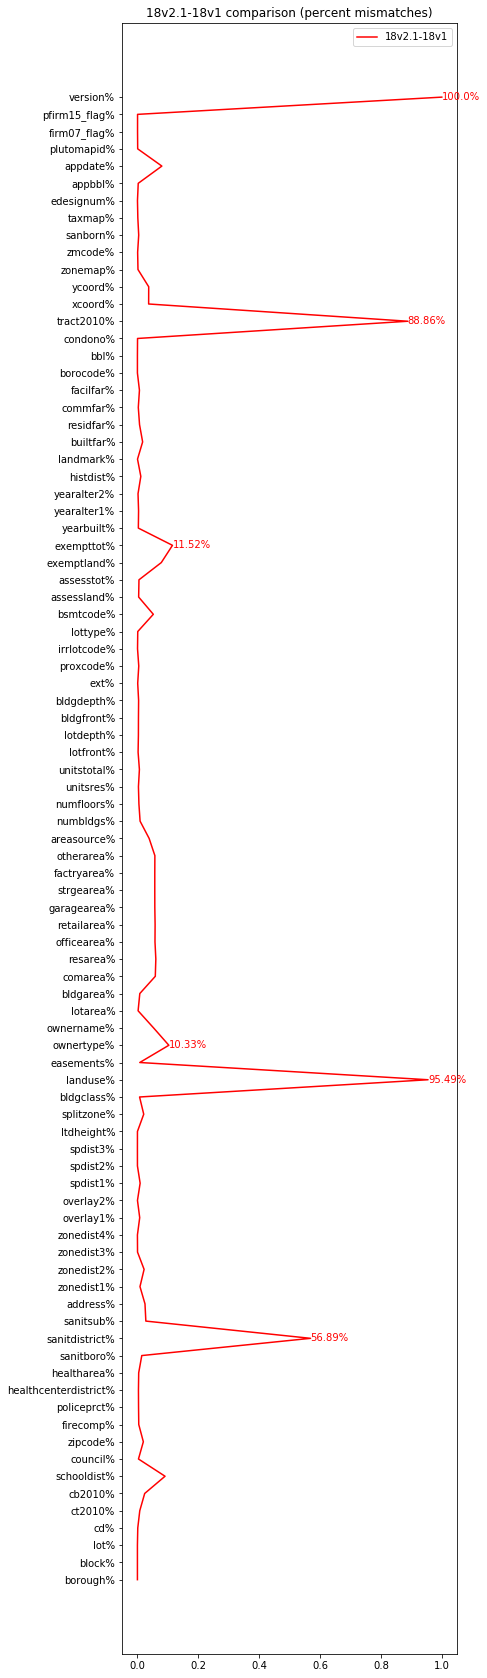

In [10]:
plt.figure(figsize=(6, 30))
plt.plot(results_df.iloc[0, :], range(87), label = '18v2.1-18v1', color = 'red')
label = list(results_df.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass

plt.yticks(range(87), results_df.columns, rotation='horizontal')
plt.title('18v2.1-18v1 comparison (percent mismatches)')
plt.legend()
plt.savefig('18v2.1-18v1_comparison.png', bbox_inches='tight')
plt.show()

In [11]:
results_df.to_csv('results_18v1_18v2_1.csv', index = False)
condo_results_df.to_csv('condo_results_18v1_18v2_1.csv', index = False)

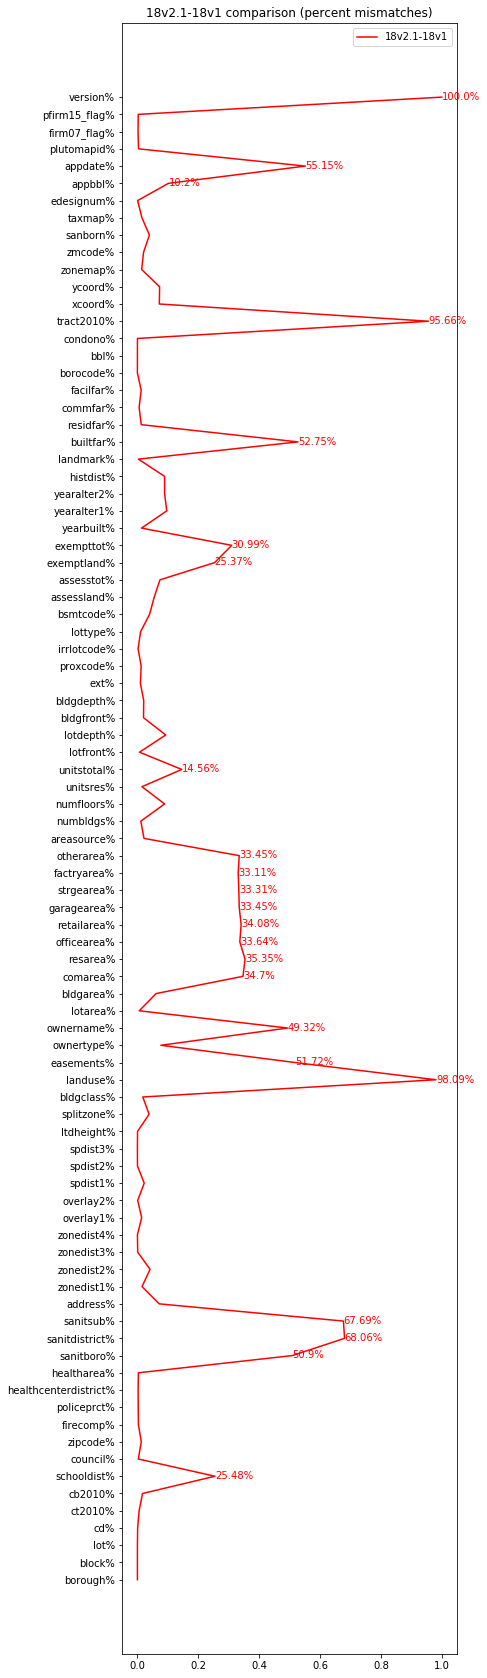

In [12]:
plt.figure(figsize=(6, 30))
plt.plot(condo_results_df.iloc[0, :], range(87), label = '18v2.1-18v1', color = 'red')
label = list(condo_results_df.iloc[0, :])

for i in range(len(label)):
    if label[i] >= 0.1:
        plt.text(x = label[i] , y = i-0.15, s = '{}%'.format(np.round(label[i]*100, 2)), size = 10, color = 'red')
    else: 
        pass

plt.yticks(range(87), condo_results_df.columns, rotation='horizontal')
plt.title('18v2.1-18v1 comparison (percent mismatches)')
plt.legend()
plt.savefig('18v2.1-18v1_comparison.png', bbox_inches='tight')
plt.show()